In [25]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [26]:
save_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after"

exploded40_day7 = torch.load(os.path.join(save_dir, 'exploded40_day7.pt'))
exploded40_day10 = torch.load(os.path.join(save_dir, 'exploded40_day10.pt'))


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\1313179897.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exploded40_day7 = torch.load(os.path.join(save_dir, 'explod

In [27]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(exploded40_day7)}")
print(f"Number of training Day 10 features: {len(exploded40_day10)}")


Number of training Day 7 features: 38
Number of training Day 10 features: 38


In [28]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {exploded40_day7.shape}")
print(f"Shape of training Day 10 features: {exploded40_day10.shape}")


Shape of training Day 7 features: torch.Size([38, 20])
Shape of training Day 10 features: torch.Size([38, 20])


In [30]:
exploded40_day7_scaled = (exploded40_day7 - train_day7_feats_mean) / train_day7_feats_std
exploded40_day10_scaled = (exploded40_day10 - train_day10_feats_mean) / train_day10_feats_std

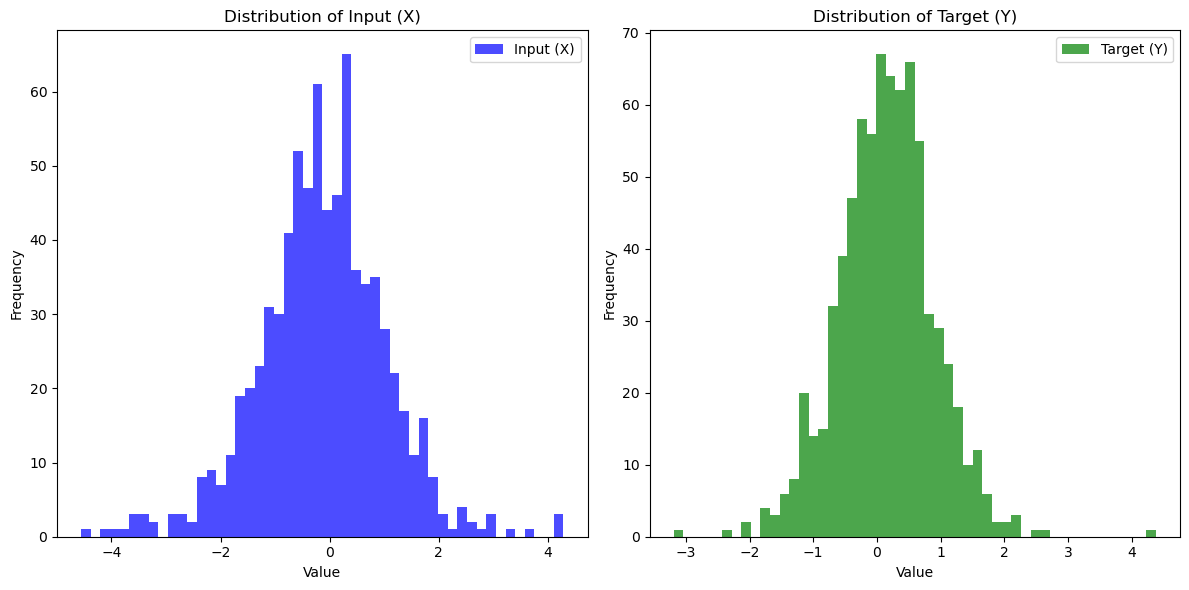

Input (X): Mean=-0.1305, Std=1.1590
Target (Y): Mean=0.1484, Std=0.7581


In [31]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
exploded40_day7_flat = exploded40_day7.flatten().cpu().numpy()
exploded40_day10_flat = exploded40_day10.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(exploded40_day7_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(exploded40_day10_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={exploded40_day7.mean():.4f}, Std={exploded40_day7.std():.4f}")
print(f"Target (Y): Mean={exploded40_day10.mean():.4f}, Std={exploded40_day10.std():.4f}")


In [32]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=20, output_size=20):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [34]:
# Define the directory where models are saved
load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join(load_dir, 'best_model_fold_1.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

Loaded model from C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after\best_model_fold_1.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\1700117121.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded and processed
with torch.no_grad():
    exploded40_day7_minmaxed = exploded40_day7_minmaxed.to(device)
    exploded40_day10_minmaxed = exploded40_day10_minmaxed.to(device)

    predicted_day10 = model(exploded40_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Calculate metrics
# MSE loss
mse_per_vector = mse_loss_fn(exploded40_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)
mse_values = mse_per_vector.cpu().numpy()

# Euclidean distance
euclidean_distances = torch.norm(predicted_day10 - exploded40_day10_minmaxed, dim=1, p=2).cpu().numpy()

# Cosine distance (1 - cosine similarity)
cosine_distances = (1 - F.cosine_similarity(predicted_day10, exploded40_day10_minmaxed, dim=1)).cpu().numpy()

# Function to calculate statistics and plot distributions
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean()
    std_val = values.std()
    min_val = values.min()
    max_val = values.max()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances, "Cosine Distance Distribution", "Cosine Distance")


In [36]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
exploded40_day7_minmaxed = exploded40_day7_scaled.to(device)
exploded40_day10_minmaxed = exploded40_day10_scaled.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []

# Loop through each feature vector
for i in range(exploded40_day7_minmaxed.shape[0]):
    exploded40_day7 = exploded40_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    exploded40_day10 = exploded40_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(exploded40_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, exploded40_day10).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - exploded40_day10, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, exploded40_day10, dim=1).item()
    cosine_distances.append(cosine_distance)

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)




In [37]:
import pandas as pd

# Create a DataFrame with the metrics
ex_data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances  # List of Cosine distances
}
df = pd.DataFrame(ex_data)

# Specify the desired name for the CSV file
file_path = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\explod.csv"  

# Save to a CSV file
df.to_csv(file_path, index=False) 


In [1]:
import pandas as pd
import torch
# Load the CSV file
df = pd.read_csv("explod.csv")

# Access the metrics
mse_values = df["MSE"].tolist()
euclidean_distances = df["Euclidean Distance"].tolist()
cosine_distances = df["Cosine Distance"].tolist()

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)

# Example: Print statistics
print(f"Mean MSE: {df['MSE'].mean():.4f}")
print(f"Max Euclidean Distance: {df['Euclidean Distance'].max():.4f}")


Mean MSE: 0.0276
Max Euclidean Distance: 5.0550


In [2]:
len(mse_values)

40

MSE Loss Distribution - Mean: 0.0276, Std: 0.0115, Min: 0.0071, Max: 0.0499


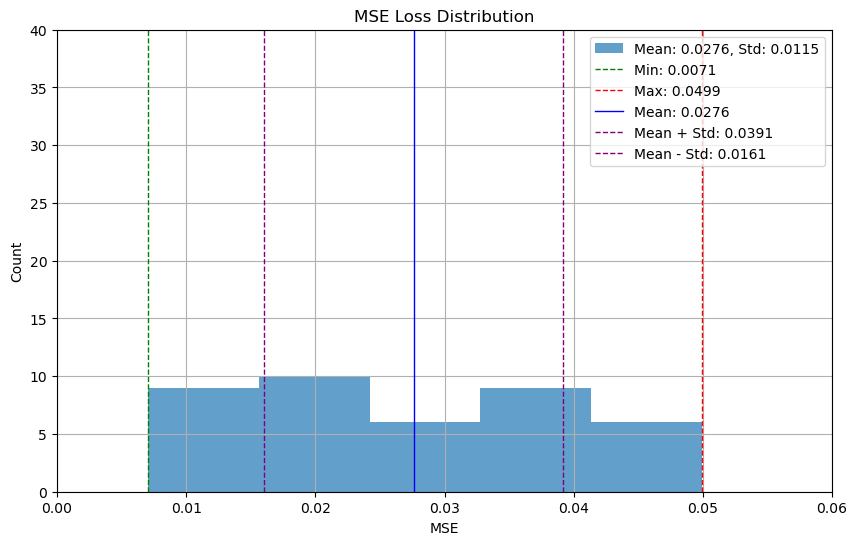

Euclidean Distance Distribution - Mean: 3.6734, Std: 0.8097, Min: 1.9002, Max: 5.0550


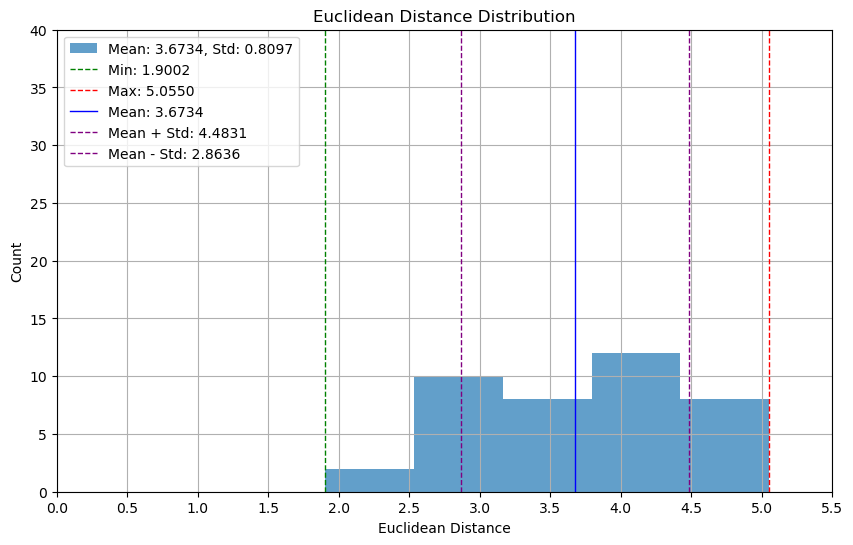

Cosine Distance Distribution - Mean: 0.4913, Std: 0.1035, Min: 0.1948, Max: 0.6801


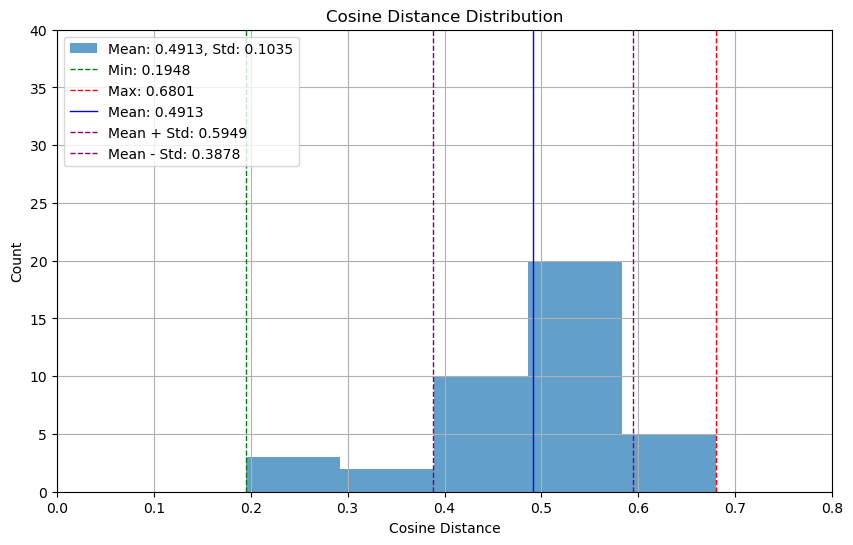

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    
    # Add vertical lines for min, max, mean, and std
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=1, label=f"Mean: {mean_val:.4f}")
    plt.axvline(mean_val + std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean + Std: {mean_val + std_val:.4f}")
    plt.axvline(mean_val - std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean - Std: {mean_val - std_val:.4f}")
    
    # Plot settings
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.01, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.5, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.1, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)


# Function to calculate and plot the distribution
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values_tensor, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances_tensor, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances_tensor, "Cosine Distance Distribution", "Cosine Distance")

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.005, 
    y_interval=5, 
    bins=12  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.25, 
    y_interval=5, 
    bins=22  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.05, 
    y_interval=5, 
    bins=16  # Adjust bins to align with the intervals
)


In [50]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [39]:
save_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after"

inference_sd_day7 = torch.load(os.path.join(save_dir, 'sd_day7.pt'))
inference_sd_day10 = torch.load(os.path.join(save_dir, 'sd_day10.pt'))


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\3871161863.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_sd_day7 = torch.load(os.path.join(save_dir, 'sd_d

In [40]:
inference_sd_day7.dtype

torch.float32

In [41]:
inference_sd_day10.dtype

torch.float32

In [42]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(inference_sd_day7)}")
print(f"Number of training Day 10 features: {len(inference_sd_day10)}")


Number of training Day 7 features: 29
Number of training Day 10 features: 29


In [43]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {inference_sd_day7.shape}")
print(f"Shape of training Day 10 features: {inference_sd_day10.shape}")


Shape of training Day 7 features: torch.Size([29, 20])
Shape of training Day 10 features: torch.Size([29, 20])


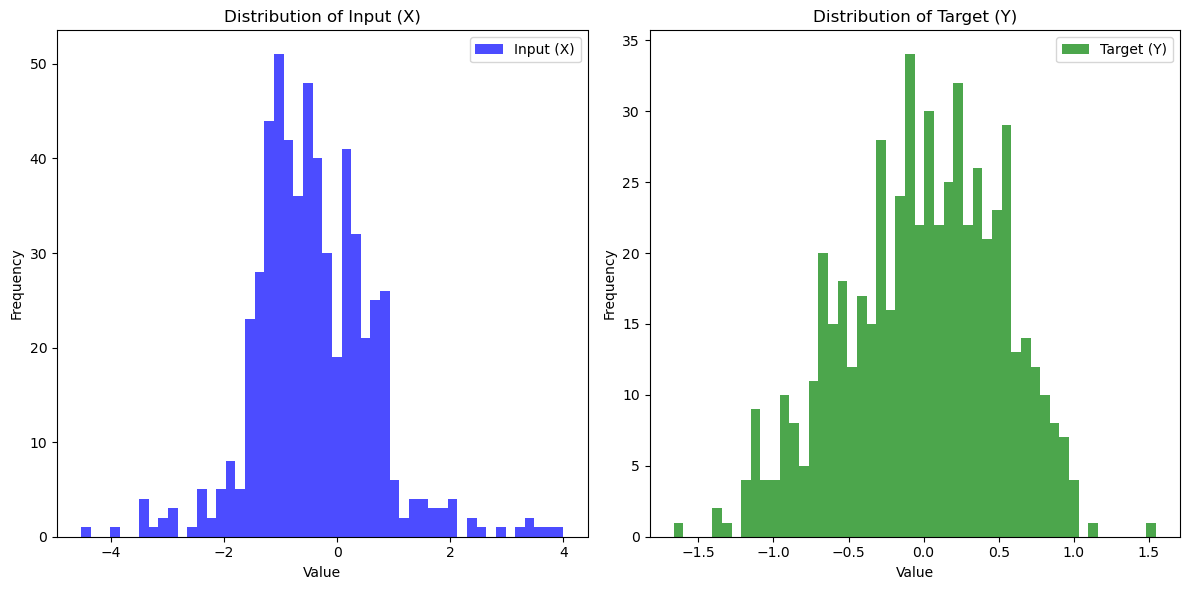

Input (X): Mean=-0.4119, Std=1.0500
Target (Y): Mean=-0.0071, Std=0.5231


In [44]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
inference_sd_day7_flat = inference_sd_day7.flatten().cpu().numpy()
inference_sd_day10_flat = inference_sd_day10.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(inference_sd_day7_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(inference_sd_day10_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={inference_sd_day7.mean():.4f}, Std={inference_sd_day7.std():.4f}")
print(f"Target (Y): Mean={inference_sd_day10.mean():.4f}, Std={inference_sd_day10.std():.4f}")


In [45]:
inference_sd_day7_scaled = (inference_sd_day7 - train_day7_feats_mean) / train_day7_feats_std
inference_sd_day10_scaled = (inference_sd_day10 - train_day10_feats_mean) / train_day10_feats_std

In [46]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=20, output_size=20):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [48]:
# Define the directory where models are saved
load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join(load_dir, 'best_model_fold_1.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

Loaded model from C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after\best_model_fold_1.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\1700117121.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded and processed
with torch.no_grad():
    inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
    inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

    predicted_day10 = model(inference_sd_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Calculate metrics
# MSE loss
mse_per_vector = mse_loss_fn(inference_sd_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)
mse_values = mse_per_vector.cpu().numpy()

# Euclidean distance
euclidean_distances = torch.norm(predicted_day10 - inference_sd_day10_minmaxed, dim=1, p=2).cpu().numpy()

# Cosine distance (1 - cosine similarity)
cosine_distances = (1 - F.cosine_similarity(predicted_day10, inference_sd_day10_minmaxed, dim=1)).cpu().numpy()

# Function to calculate statistics and plot distributions
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean()
    std_val = values.std()
    min_val = values.min()
    max_val = values.max()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances, "Cosine Distance Distribution", "Cosine Distance")


In [49]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
inference_sd_day7_minmaxed = inference_sd_day7_scaled.to(device)
inference_sd_day10_minmaxed = inference_sd_day10_scaled.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []

# Loop through each feature vector
for i in range(inference_sd_day7_minmaxed.shape[0]):
    inference_sd_day7 = inference_sd_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    inference_sd_day10 = inference_sd_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(inference_sd_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, inference_sd_day10).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - inference_sd_day10, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, inference_sd_day10, dim=1).item()
    cosine_distances.append(cosine_distance)

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)



In [50]:
import pandas as pd

# Create a DataFrame with the metrics
sd_data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances  # List of Cosine distances
}
df = pd.DataFrame(sd_data)

# Specify the desired name for the CSV file
file_path = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\sd.csv"  

# Save to a CSV file
df.to_csv(file_path, index=False) 


In [1]:
import pandas as pd
import torch
# Load the CSV file
df = pd.read_csv("sd.csv")

# Access the metrics
mse_values = df["MSE"].tolist()
euclidean_distances = df["Euclidean Distance"].tolist()
cosine_distances = df["Cosine Distance"].tolist()

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)

# Example: Print statistics
print(f"Mean MSE: {df['MSE'].mean():.4f}")
print(f"Max Euclidean Distance: {df['Euclidean Distance'].max():.4f}")


Mean MSE: 0.0356
Max Euclidean Distance: 5.4003


In [2]:
len(mse_values)

29

MSE Loss Distribution - Mean: 0.0356, Std: 0.0089, Min: 0.0221, Max: 0.0570


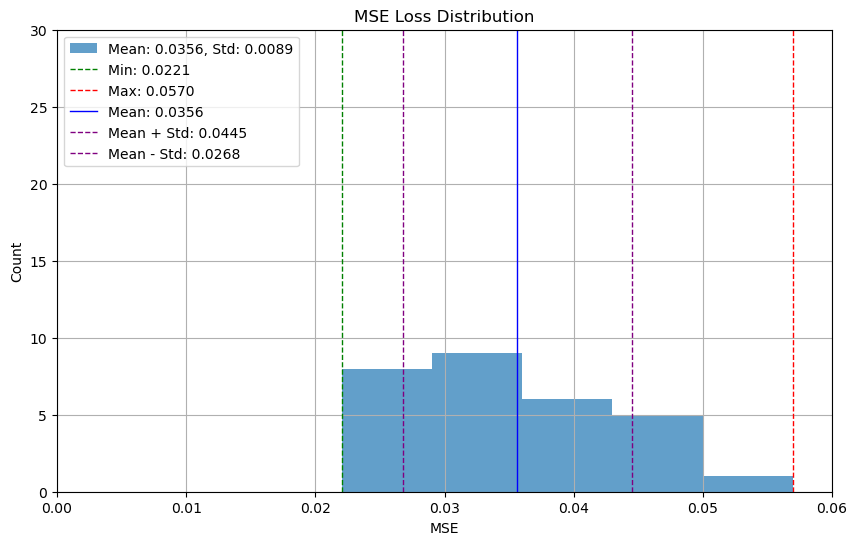

Euclidean Distance Distribution - Mean: 4.2391, Std: 0.5298, Min: 3.3615, Max: 5.4003


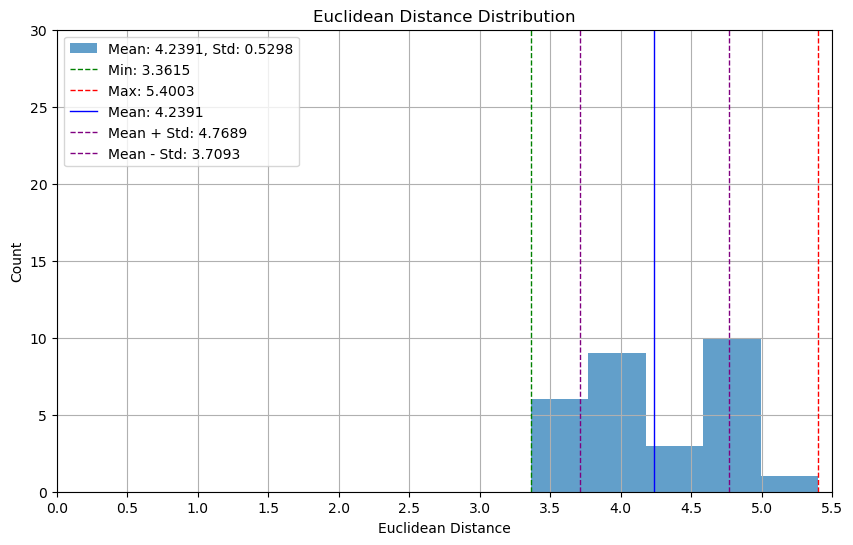

Cosine Distance Distribution - Mean: 0.6492, Std: 0.0840, Min: 0.4693, Max: 0.7816


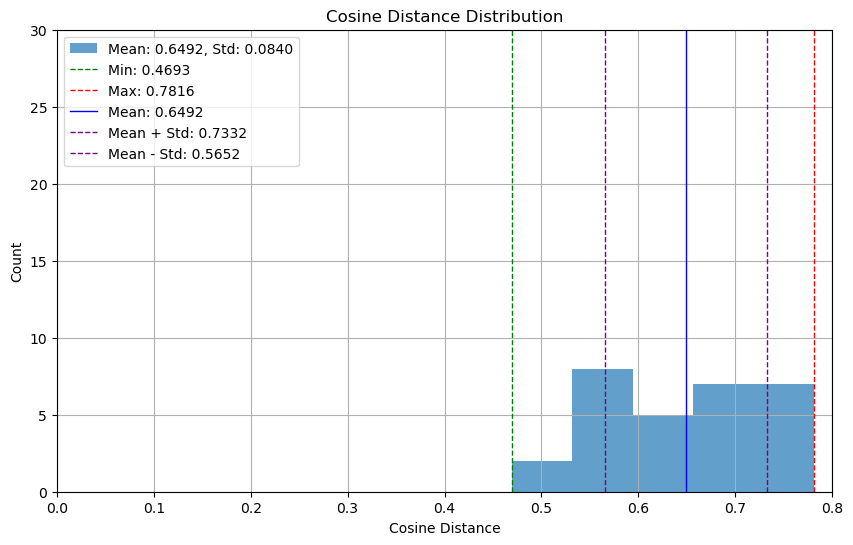

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    
    # Add vertical lines for min, max, mean, and std
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=1, label=f"Mean: {mean_val:.4f}")
    plt.axvline(mean_val + std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean + Std: {mean_val + std_val:.4f}")
    plt.axvline(mean_val - std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean - Std: {mean_val - std_val:.4f}")
    
    # Plot settings
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.01, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.5, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.1, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)


# Function to calculate and plot the distribution
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values_tensor, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances_tensor, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances_tensor, "Cosine Distance Distribution", "Cosine Distance")


import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.005, 
    y_interval=5, 
    bins=12  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.25, 
    y_interval=5, 
    bins=22  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.05, 
    y_interval=5, 
    bins=16  # Adjust bins to align with the intervals
)


In [19]:
# std deviations are different. but no so much different.

SyntaxError: invalid syntax (2187169062.py, line 1)

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [2]:
save_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after"

train_day7_feats = torch.load(os.path.join(save_dir, 'controlall_day7.pt'))
train_day10_feats = torch.load(os.path.join(save_dir, 'controlall_day10.pt'))


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\3152414893.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_day7_feats = torch.load(os.path.join(save_dir, 'contr

In [3]:
# Load training features
#train_day7_feats = torch.load('train_day7_control.pt')
#train_day10_feats = torch.load('train_day10_control.pt')


In [5]:
train_day7_feats.shape

torch.Size([130, 20])

In [6]:
train_day7_feats.dtype

torch.float32

In [7]:
train_day10_feats.dtype

torch.float32

In [8]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(train_day7_feats)}")
print(f"Number of training Day 10 features: {len(train_day10_feats)}")


Number of training Day 7 features: 130
Number of training Day 10 features: 130


In [9]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {train_day7_feats.shape}")
print(f"Shape of training Day 10 features: {train_day10_feats.shape}")


Shape of training Day 7 features: torch.Size([130, 20])
Shape of training Day 10 features: torch.Size([130, 20])


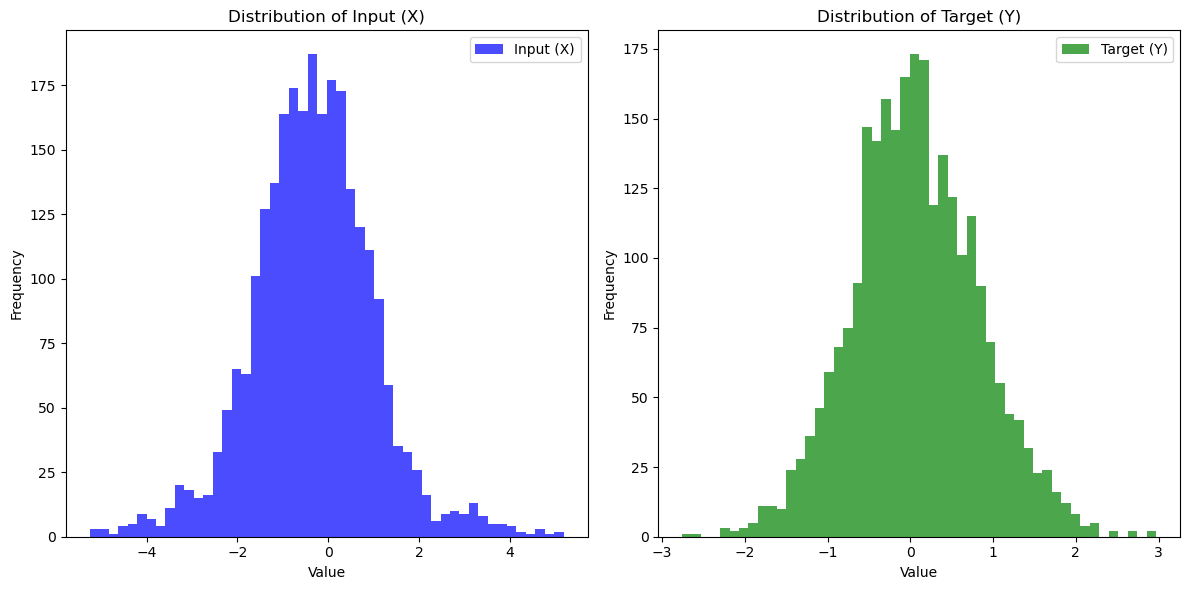

Input (X): Mean=-0.3310, Std=1.3456
Target (Y): Mean=0.0641, Std=0.7642


In [10]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy()
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={train_day7_feats_flat.mean():.4f}, Std={train_day7_feats_flat.std():.4f}")
print(f"Target (Y): Mean={train_day10_feats_flat.mean():.4f}, Std={train_day10_feats_flat.std():.4f}")


In [11]:
def z_score_normalization(tensor):
    """
    Perform Z-score normalization on a PyTorch tensor.
    
    Args:
        tensor (torch.Tensor): Input tensor to be normalized.
    
    Returns:
        torch.Tensor: Z-score normalized tensor.
        torch.Tensor: Mean of the input tensor.
        torch.Tensor: Standard deviation of the input tensor.
    """
    mean = tensor.mean()
    std = tensor.std()
    z_score_normalized = (tensor - mean) / std
    return z_score_normalized, mean, std


In [12]:
# Z-Score Normalization for train_day7_feats
train_day7_feats_scaled, train_day7_feats_mean, train_day7_feats_std = z_score_normalization(train_day7_feats)
print("Train Day 7 Mean:", train_day7_feats_mean)
print("Train Day 7 Std Dev:", train_day7_feats_std)

# Z-Score Normalization for train_day10_feats
train_day10_feats_scaled, train_day10_feats_mean, train_day10_feats_std = z_score_normalization(train_day10_feats)
print("Train Day 10 Mean:", train_day10_feats_mean)
print("Train Day 10 Std Dev:", train_day10_feats_std)


Train Day 7 Mean: tensor(-0.3310)
Train Day 7 Std Dev: tensor(1.3458)
Train Day 10 Mean: tensor(0.0641)
Train Day 10 Std Dev: tensor(0.7643)


In [18]:
train_day7_feats_minmaxed = train_day7_feats_scaled
train_day10_feats_minmaxed = train_day10_feats_scaled

In [19]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FeaturePredictor(nn.Module):
    def __init__(self, input_size=20, output_size=20):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [20]:
# Define the directory where models are saved
load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join(load_dir, 'best_model_fold_1.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

Loaded model from C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after\best_model_fold_1.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_26156\1700117121.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded and processed
with torch.no_grad():
    train_day7_feats_minmaxed = train_day7_feats_minmaxed.to(device)
    train_day10_feats_minmaxed = train_day10_feats_minmaxed.to(device)

    predicted_day10 = model(train_day7_feats_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Calculate metrics
# MSE loss
mse_per_vector = mse_loss_fn(train_day10_feats_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)
mse_values = mse_per_vector.cpu().numpy()

# Euclidean distance
euclidean_distances = torch.norm(predicted_day10 - train_day10_feats_minmaxed, dim=1, p=2).cpu().numpy()

# Cosine distance (1 - cosine similarity)
cosine_distances = (1 - F.cosine_similarity(predicted_day10, train_day10_feats_minmaxed, dim=1)).cpu().numpy()

# Function to calculate statistics and plot distributions
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean()
    std_val = values.std()
    min_val = values.min()
    max_val = values.max()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances, "Cosine Distance Distribution", "Cosine Distance")


In [21]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = train_day7_feats_minmaxed.to(device)
train_day10_feats_minmaxed = train_day10_feats_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)



In [22]:
import pandas as pd

# Create a DataFrame with the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances  # List of Cosine distances
}
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
file_path = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\control.csv"  

# Save to a CSV file
df.to_csv(file_path, index=False) 


In [1]:
import pandas as pd
import torch
# Load the CSV file
df = pd.read_csv("control.csv")

# Access the metrics
mse_values = df["MSE"].tolist()
euclidean_distances = df["Euclidean Distance"].tolist()
cosine_distances = df["Cosine Distance"].tolist()

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)

# Example: Print statistics
print(f"Mean MSE: {df['MSE'].mean():.4f}")
print(f"Max Euclidean Distance: {df['Euclidean Distance'].max():.4f}")


Mean MSE: 0.0074
Max Euclidean Distance: 4.6737


In [2]:
len(mse_values)

130

MSE Loss Distribution - Mean: 0.0074, Std: 0.0057, Min: 0.0013, Max: 0.0427


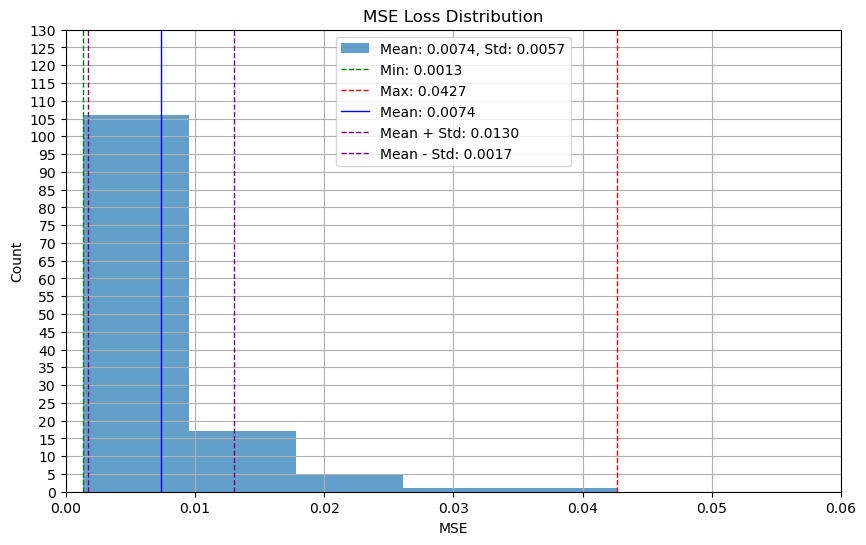

Euclidean Distance Distribution - Mean: 1.8459, Std: 0.6116, Min: 0.8123, Max: 4.6737


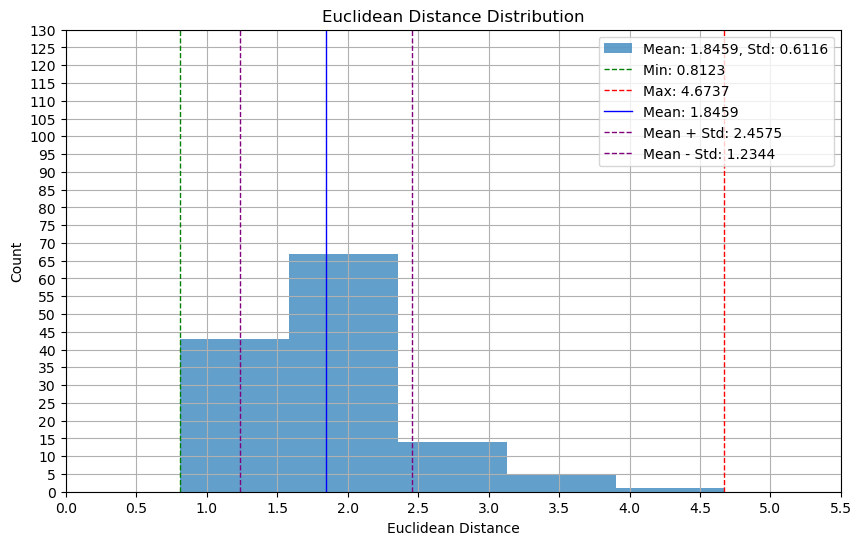

Cosine Distance Distribution - Mean: 0.1329, Std: 0.0928, Min: 0.0214, Max: 0.5739


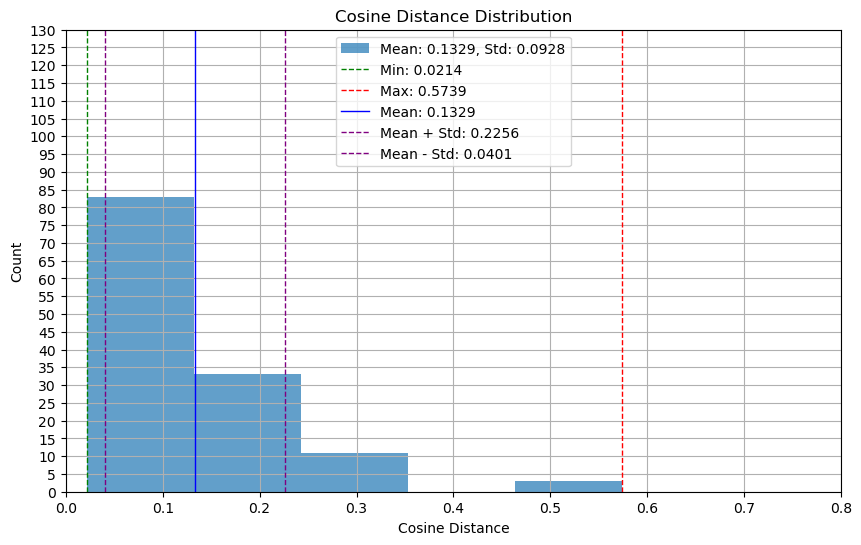

In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    
    # Add vertical lines for min, max, mean, and std
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=1, label=f"Mean: {mean_val:.4f}")
    plt.axvline(mean_val + std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean + Std: {mean_val + std_val:.4f}")
    plt.axvline(mean_val - std_val, color='purple', linestyle='--', linewidth=1, label=f"Mean - Std: {mean_val - std_val:.4f}")
    
    # Plot settings
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.01, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.5, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.1, 
    y_interval=5, 
    bins=5  # Adjust bins to align with the intervals
)


# Function to calculate and plot the distribution
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values_tensor, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances_tensor, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances_tensor, "Cosine Distance Distribution", "Cosine Distance")


import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Function to calculate and plot the distribution with custom axes
def plot_custom_distribution(values, title, xlabel, x_max, x_interval, y_interval, bins):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis and y-axis ticks
    plt.xlim(0, x_max)
    plt.xticks(torch.arange(0, x_max + x_interval, x_interval).cpu().numpy())
    plt.yticks(torch.arange(0, values.numel() + y_interval, y_interval).cpu().numpy())
    plt.show()

# Plot the distributions
plot_custom_distribution(
    mse_values_tensor, 
    "MSE Loss Distribution", 
    "MSE", 
    x_max=0.06, 
    x_interval=0.005, 
    y_interval=5, 
    bins=12  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    euclidean_distances_tensor, 
    "Euclidean Distance Distribution", 
    "Euclidean Distance", 
    x_max=5.5, 
    x_interval=0.25, 
    y_interval=5, 
    bins=22  # Adjust bins to align with the intervals
)

plot_custom_distribution(
    cosine_distances_tensor, 
    "Cosine Distance Distribution", 
    "Cosine Distance", 
    x_max=0.8, 
    x_interval=0.05, 
    y_interval=5, 
    bins=16  # Adjust bins to align with the intervals
)


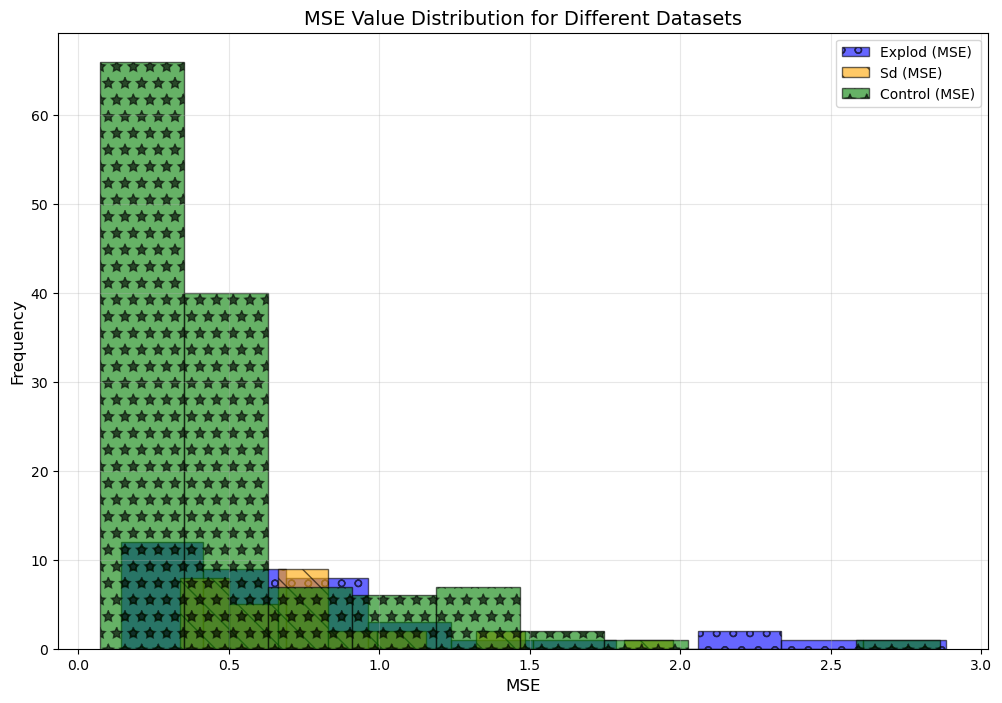

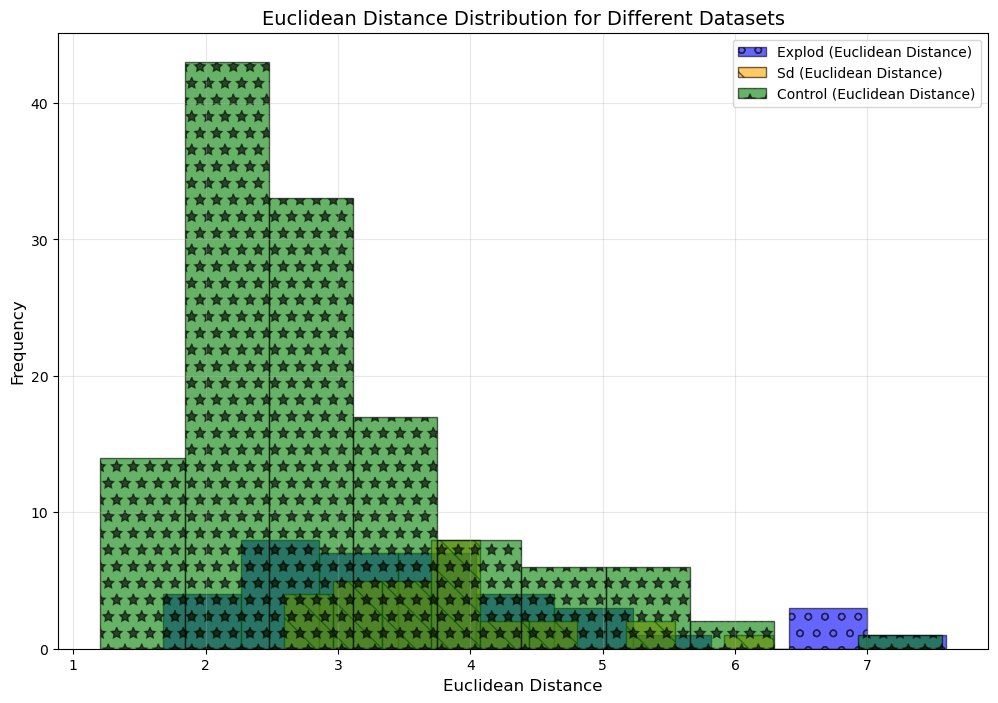

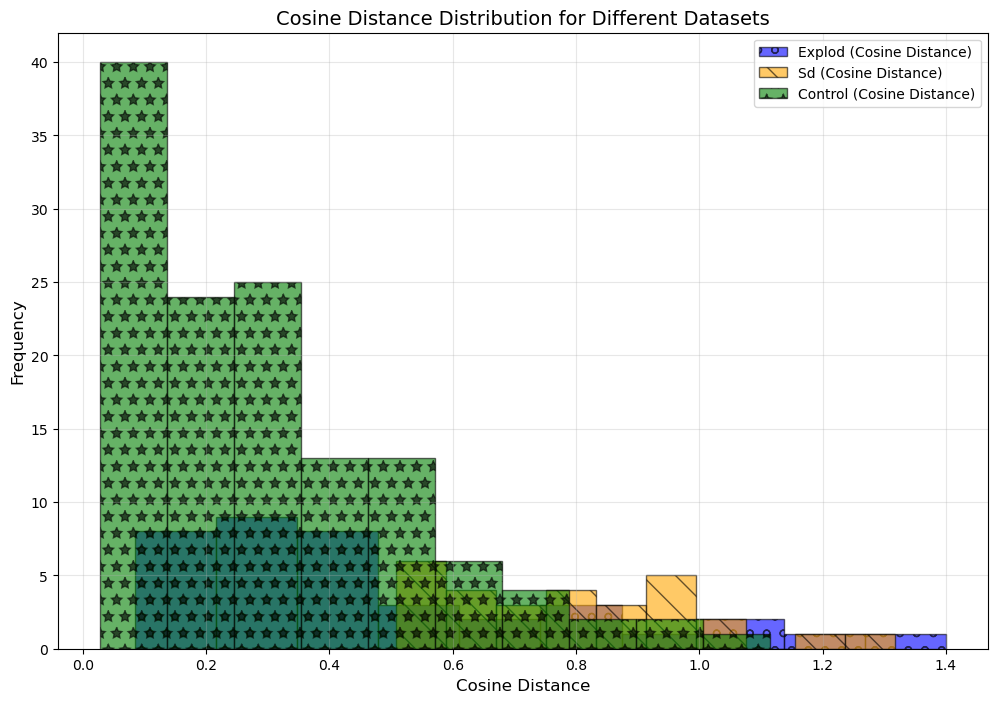

In [51]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\explod.csv"),
    "sd": pd.read_csv(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\sd.csv"),
    "control": pd.read_csv(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after\control.csv")
}

# Prepare metrics
metrics = {
    "MSE": "MSE",
    "Euclidean Distance": "Euclidean Distance",
    "Cosine Distance": "Cosine Distance"
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metrics, title, xlabel, metric_key, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        values = df[metric_key].tolist()
        plt.hist(
            values,
            bins=bins,
            alpha=0.6,
            label=f"{dataset_name.capitalize()} ({metric_key})",
            color=colors[dataset_name],
            hatch=hatch_styles[dataset_name],
            edgecolor="black"
        )
    
    # Customize plot
    plt.title(f"{title} for Different Datasets", fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot MSE, Euclidean, and Cosine Distance distributions
plot_metric_distribution(metrics, "MSE Value Distribution", "MSE", "MSE", bins=10)
plot_metric_distribution(metrics, "Euclidean Distance Distribution", "Euclidean Distance", "Euclidean Distance", bins=10)
plot_metric_distribution(metrics, "Cosine Distance Distribution", "Cosine Distance", "Cosine Distance", bins=10)


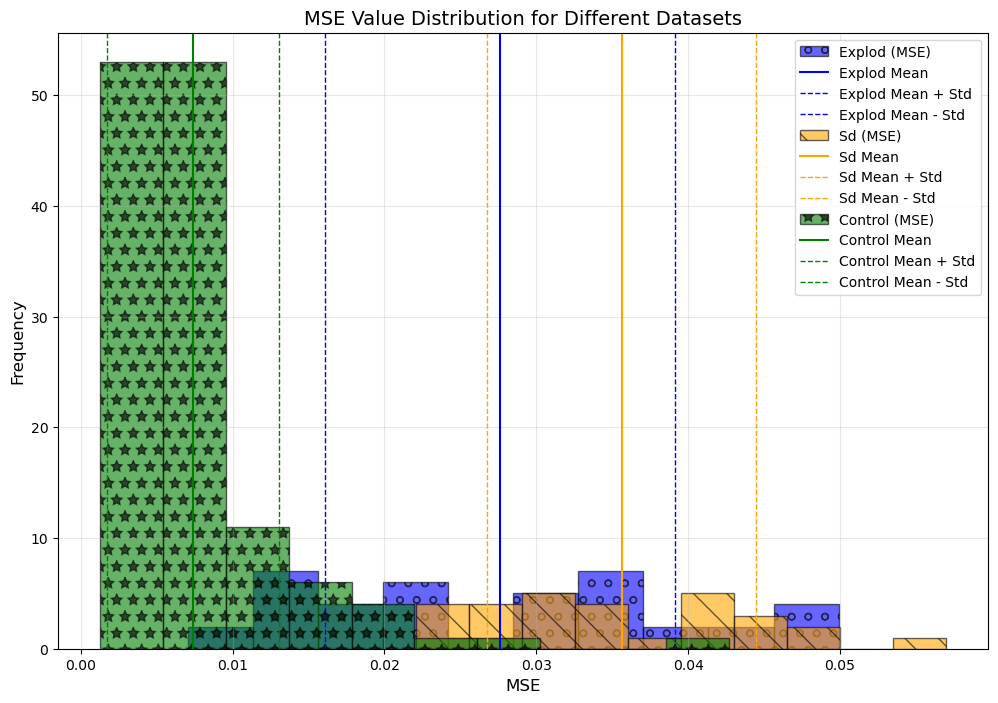

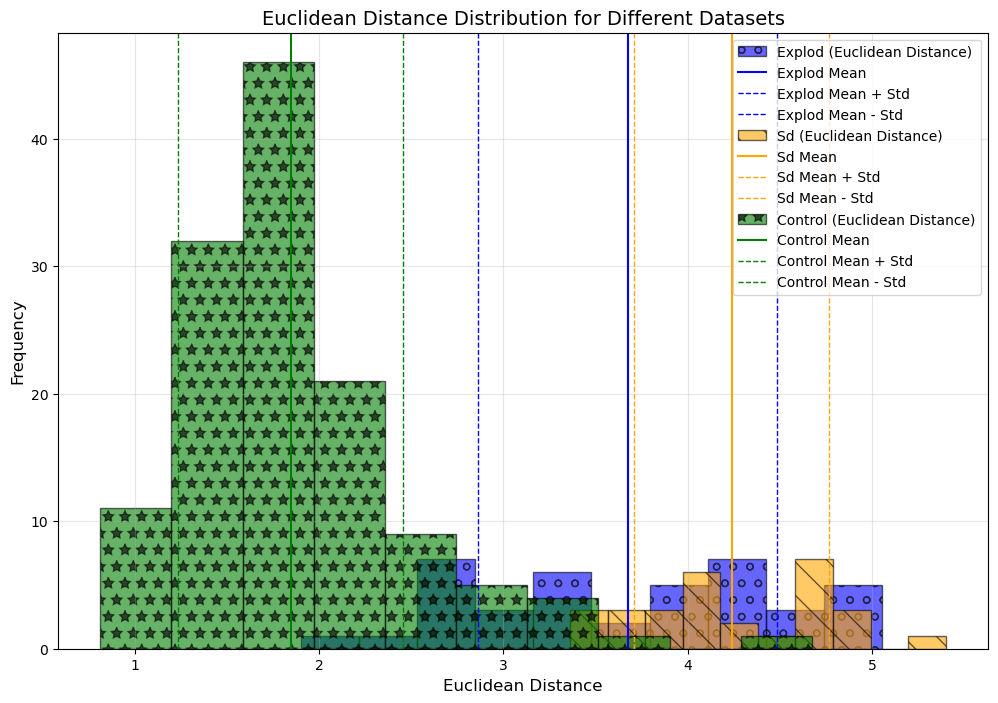

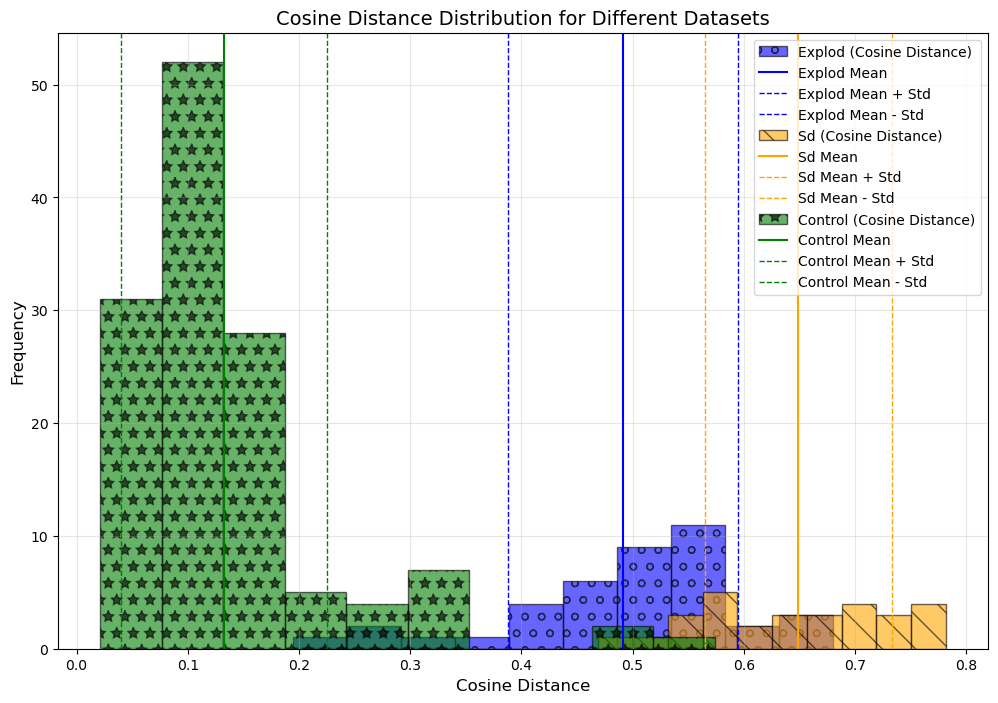

In [2]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("explod.csv"),
    "sd": pd.read_csv("sd.csv"),
    "control": pd.read_csv("control.csv")
}

# Prepare metrics
metrics = {
    "MSE": "MSE",
    "Euclidean Distance": "Euclidean Distance",
    "Cosine Distance": "Cosine Distance"
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function with standard deviation lines
def plot_metric_distribution_with_std(metrics, title, xlabel, metric_key, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        values = df[metric_key].tolist()
        mean_val = torch.tensor(values).mean().item()
        std_val = torch.tensor(values).std().item()

        # Plot histogram
        plt.hist(
            values,
            bins=bins,
            alpha=0.6,
            label=f"{dataset_name.capitalize()} ({metric_key})",
            color=colors[dataset_name],
            hatch=hatch_styles[dataset_name],
            edgecolor="black"
        )

        # Plot standard deviation lines
        plt.axvline(mean_val, color=colors[dataset_name], linestyle="-", linewidth=1.5, label=f"{dataset_name.capitalize()} Mean")
        plt.axvline(mean_val + std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean + Std")
        plt.axvline(mean_val - std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean - Std")
    
    # Customize plot
    plt.title(f"{title} for Different Datasets", fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot MSE, Euclidean, and Cosine Distance distributions with std deviation
plot_metric_distribution_with_std(metrics, "MSE Value Distribution", "MSE", "MSE", bins=10)
plot_metric_distribution_with_std(metrics, "Euclidean Distance Distribution", "Euclidean Distance", "Euclidean Distance", bins=10)
plot_metric_distribution_with_std(metrics, "Cosine Distance Distribution", "Cosine Distance", "Cosine Distance", bins=10)


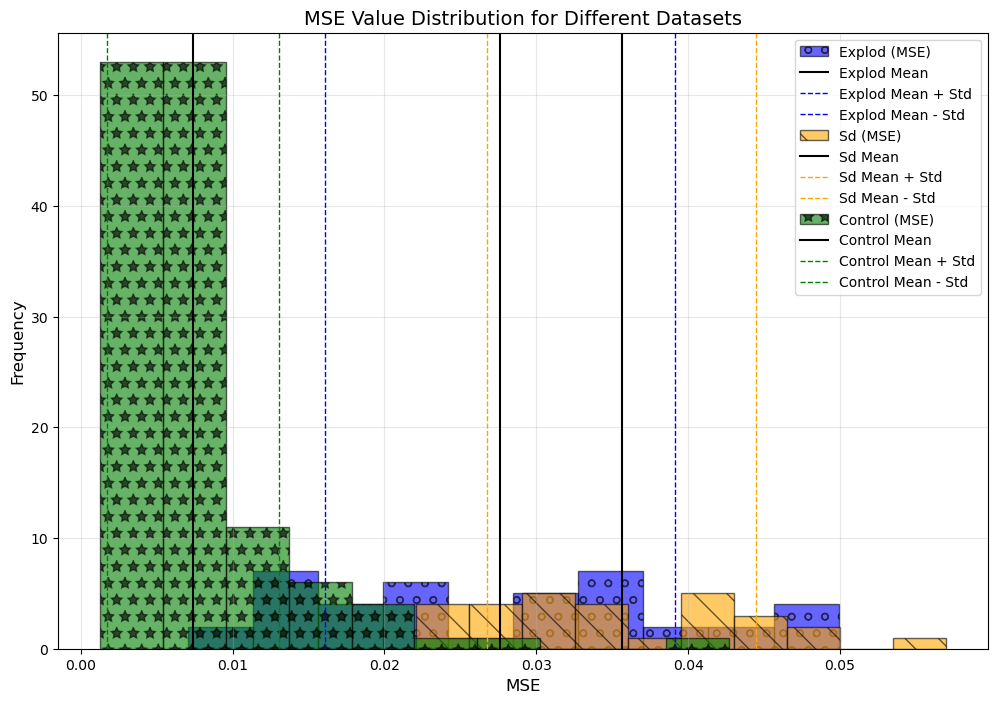

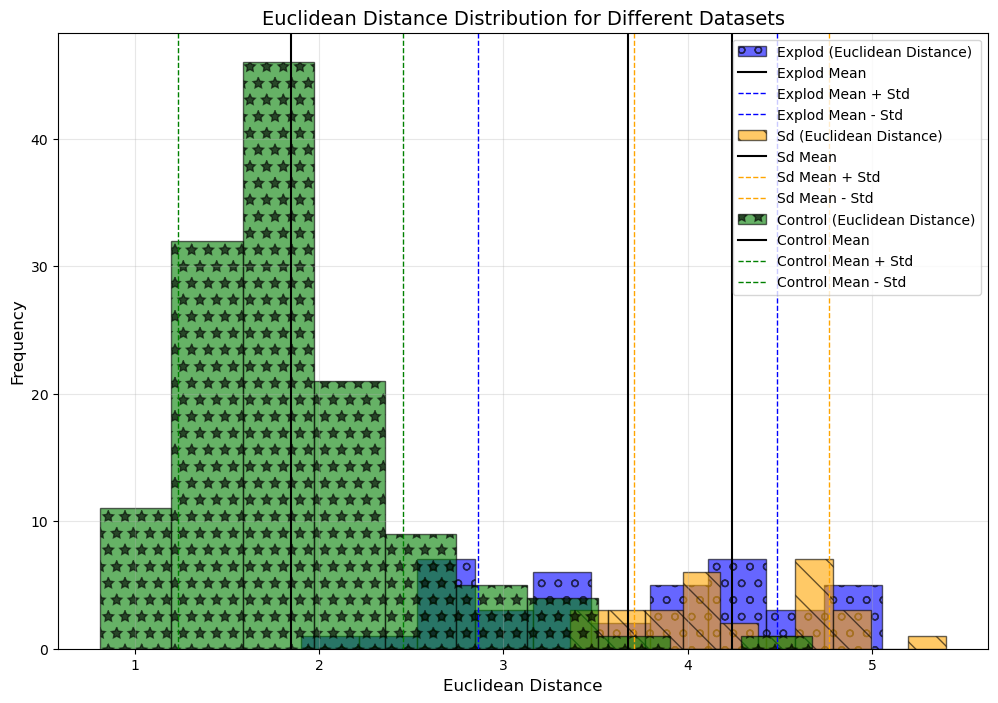

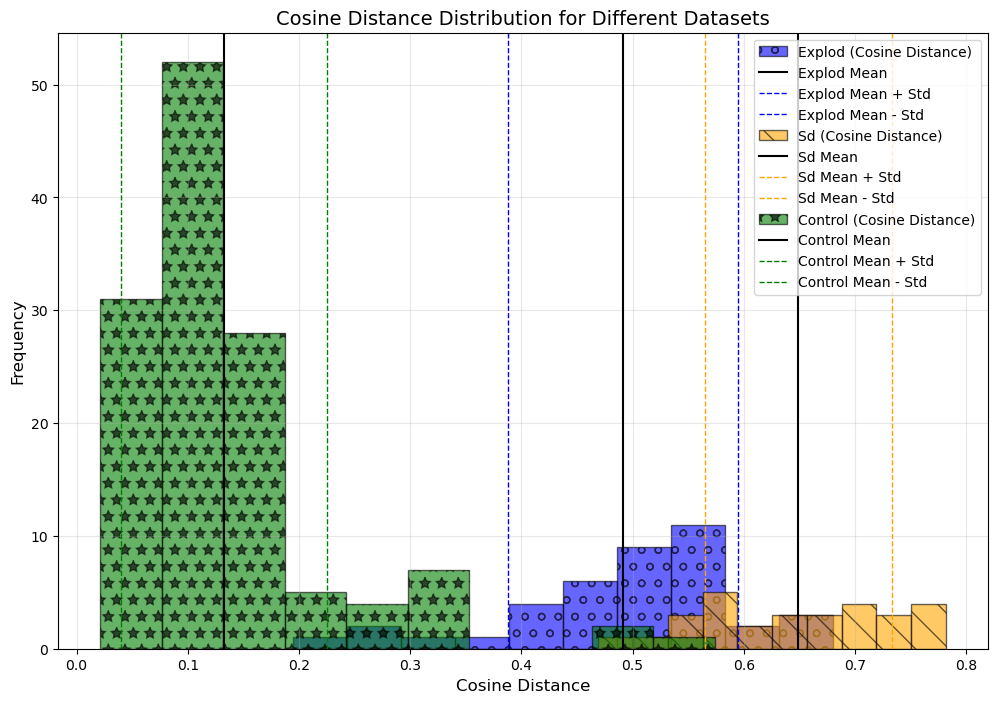

In [3]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("explod.csv"),
    "sd": pd.read_csv("sd.csv"),
    "control": pd.read_csv("control.csv")
}

# Prepare metrics
metrics = {
    "MSE": "MSE",
    "Euclidean Distance": "Euclidean Distance",
    "Cosine Distance": "Cosine Distance"
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function with standard deviation lines and black mean lines
def plot_metric_distribution_with_std(metrics, title, xlabel, metric_key, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        values = df[metric_key].tolist()
        mean_val = torch.tensor(values).mean().item()
        std_val = torch.tensor(values).std().item()

        # Plot histogram
        plt.hist(
            values,
            bins=bins,
            alpha=0.6,
            label=f"{dataset_name.capitalize()} ({metric_key})",
            color=colors[dataset_name],
            hatch=hatch_styles[dataset_name],
            edgecolor="black"
        )

        # Plot standard deviation lines
        plt.axvline(mean_val, color="black", linestyle="-", linewidth=1.5, label=f"{dataset_name.capitalize()} Mean")
        plt.axvline(mean_val + std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean + Std")
        plt.axvline(mean_val - std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean - Std")
    
    # Customize plot
    plt.title(f"{title} for Different Datasets", fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot MSE, Euclidean, and Cosine Distance distributions with std deviation
plot_metric_distribution_with_std(metrics, "MSE Value Distribution", "MSE", "MSE", bins=10)
plot_metric_distribution_with_std(metrics, "Euclidean Distance Distribution", "Euclidean Distance", "Euclidean Distance", bins=10)
plot_metric_distribution_with_std(metrics, "Cosine Distance Distribution", "Cosine Distance", "Cosine Distance", bins=10)


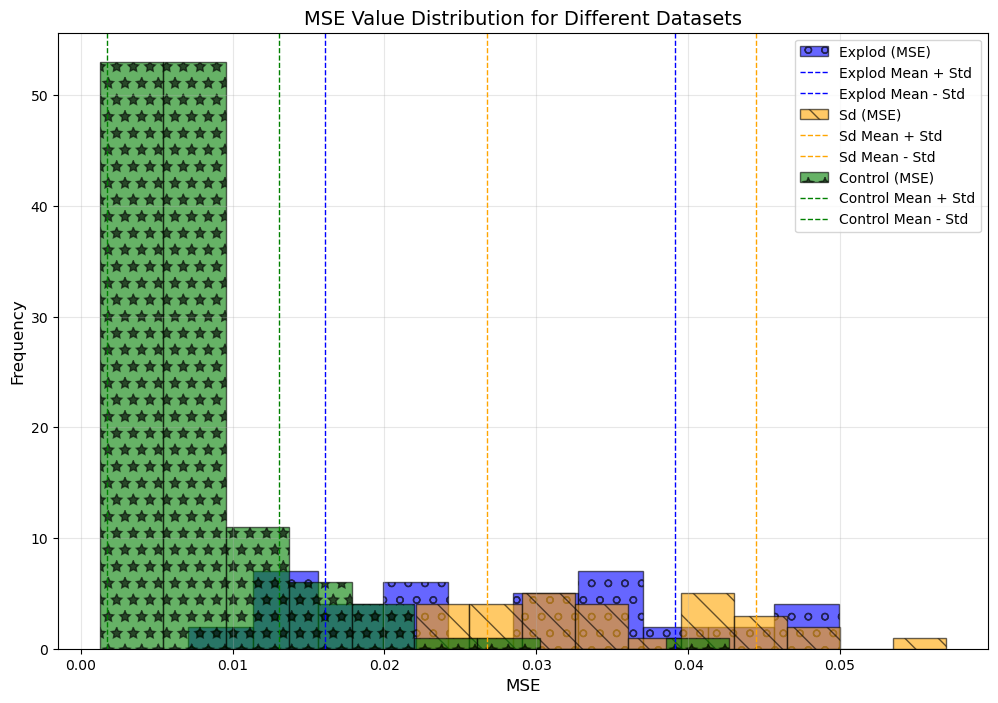

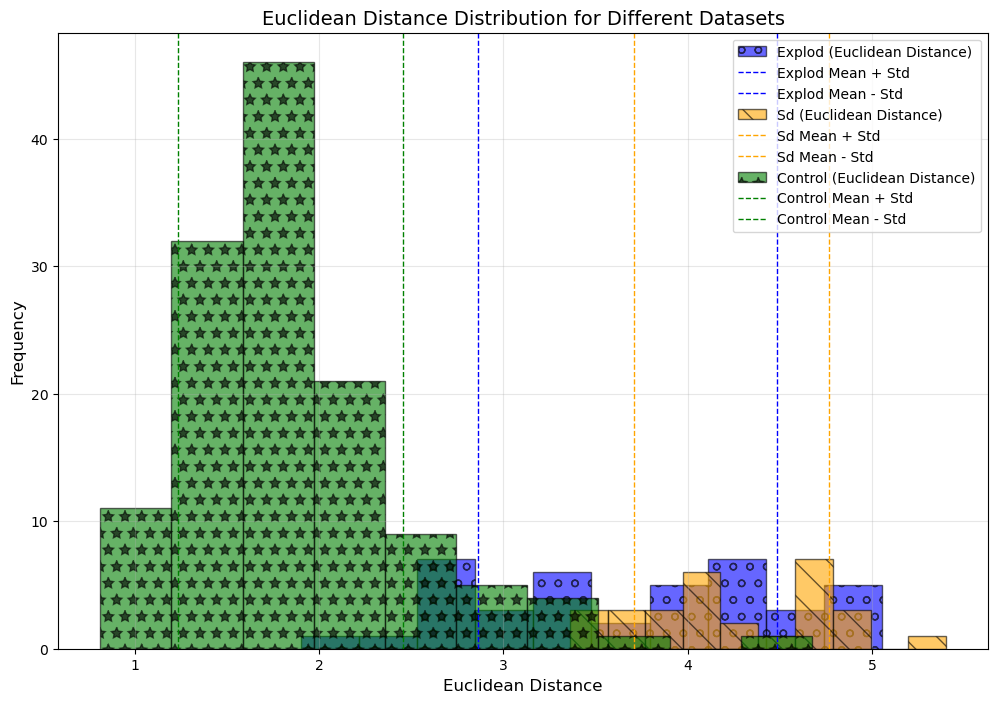

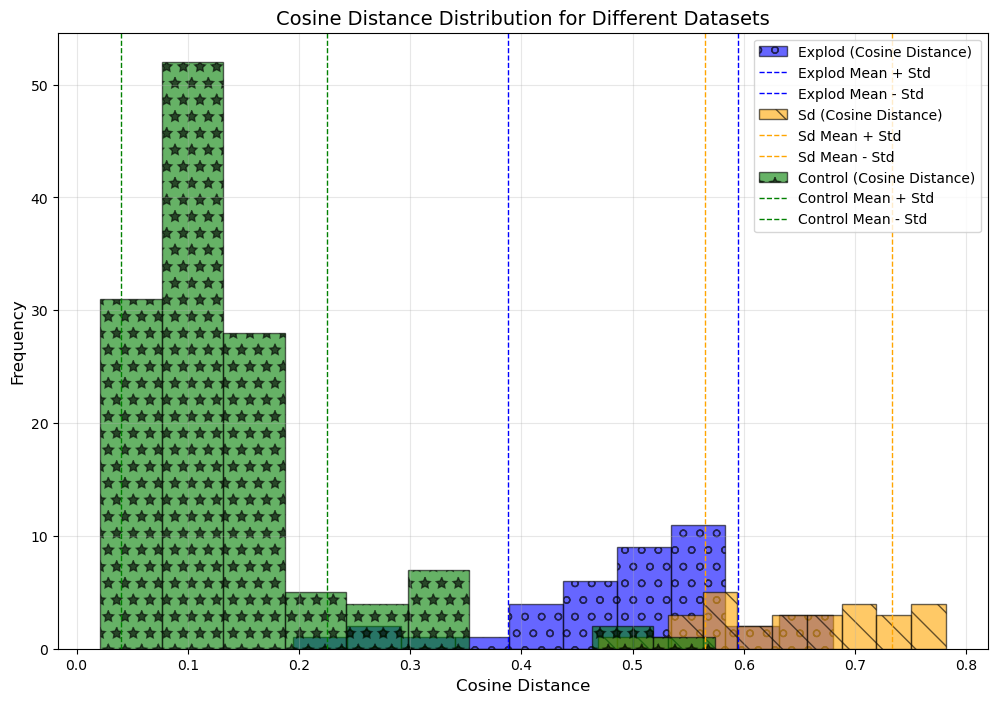

In [4]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("explod.csv"),
    "sd": pd.read_csv("sd.csv"),
    "control": pd.read_csv("control.csv")
}

# Prepare metrics
metrics = {
    "MSE": "MSE",
    "Euclidean Distance": "Euclidean Distance",
    "Cosine Distance": "Cosine Distance"
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function with standard deviation lines only (no mean lines)
def plot_metric_distribution_with_std(metrics, title, xlabel, metric_key, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        values = df[metric_key].tolist()
        mean_val = torch.tensor(values).mean().item()
        std_val = torch.tensor(values).std().item()

        # Plot histogram
        plt.hist(
            values,
            bins=bins,
            alpha=0.6,
            label=f"{dataset_name.capitalize()} ({metric_key})",
            color=colors[dataset_name],
            hatch=hatch_styles[dataset_name],
            edgecolor="black"
        )

        # Plot standard deviation lines only
        plt.axvline(mean_val + std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean + Std")
        plt.axvline(mean_val - std_val, color=colors[dataset_name], linestyle="--", linewidth=1, label=f"{dataset_name.capitalize()} Mean - Std")
    
    # Customize plot
    plt.title(f"{title} for Different Datasets", fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot MSE, Euclidean, and Cosine Distance distributions with std deviation only
plot_metric_distribution_with_std(metrics, "MSE Value Distribution", "MSE", "MSE", bins=10)
plot_metric_distribution_with_std(metrics, "Euclidean Distance Distribution", "Euclidean Distance", "Euclidean Distance", bins=10)
plot_metric_distribution_with_std(metrics, "Cosine Distance Distribution", "Cosine Distance", "Cosine Distance", bins=10)


In [21]:
import torch
from torch import nn,optim
import torchvision

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [23]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [24]:
# Reinitialize the model
model_path = r'C:\Users\k54739\saved_model\simclr_model_epoch_245.pth'
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()

# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_20960\1777071111.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [45]:
from copy import deepcopy
import torchvision.transforms.functional as TF
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [48]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10\RBTDS_6.1_G11-T01.tiff'

In [61]:
controld2exp = Preprocess_Image(path_of_image)
print(controld2exp.shape)
prep_controld2exp = controld2exp.unsqueeze(0)
print(prep_controld2exp.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


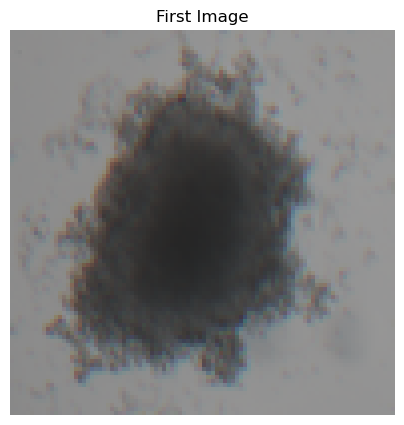

In [50]:
controld2exp_np = controld2exp.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(controld2exp_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [60]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day10\ds_6.2_gp8_B09-T01.tiff'
ds_explod = Preprocess_Image(pathimage)
print(ds_explod.shape)
prep_ds_explod = ds_explod.unsqueeze(0)
print(prep_ds_explod.shape)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


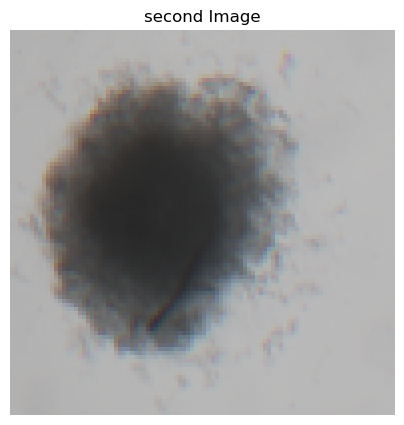

In [57]:
ds_explod_np = ds_explod.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(ds_explod_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [58]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [62]:
# Extract features for both images
controld2exp_feats = extract_features(simclr_model, prep_controld2exp)
ds_explod_feats = extract_features(simclr_model, prep_ds_explod)
print(controld2exp_feats.shape)
print(ds_explod_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [63]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(controld2exp_feats, ds_explod_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.5377793312072754


In [64]:
path = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61\B07-T01.tiff'
sd = Preprocess_Image(path)
print(sd.shape)
prep_sd = sd.unsqueeze(0)
print(prep_sd.shape)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


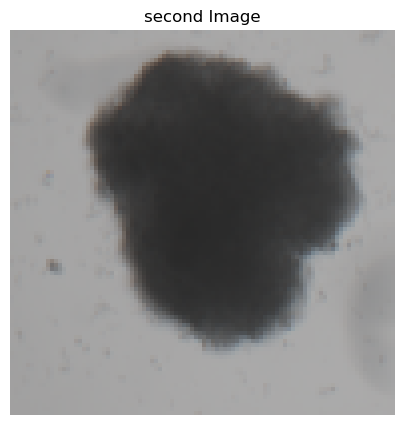

In [65]:
sd_np = sd.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(sd_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [66]:
sd_feats = extract_features(simclr_model, prep_sd)
print(sd_feats.shape)

torch.Size([1, 512])


In [67]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(controld2exp_feats, sd_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.292826771736145


In [ ]:
Inference after projection head

In [ ]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features